## MLBookCamp Homework 4


- [Course page](https://datatalks.club/courses/2021-winter-ml-zoomcamp.html)

- [Homework page](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp/04-evaluation#readme)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-04 13:51:20--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.2’

CreditScoring.csv.2 100%[===================>] 178.21K   173KB/s    in 1.0s    

2021-10-04 13:51:23 (173 KB/s) - ‘CreditScoring.csv.2’ saved [182489/182489]



### Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()


Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [8]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


In [9]:
cat_cols = df.select_dtypes(include= ['object']).columns.to_list()
num_cols = df.select_dtypes(include= ['int64']).columns.to_list()
num_cols.remove('default')

In [10]:
cat_cols, num_cols

(['home', 'marital', 'records', 'job'],
 ['seniority',
  'time',
  'age',
  'expenses',
  'income',
  'assets',
  'debt',
  'amount',
  'price'])

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [11]:
target = df['default']

In [12]:
import sklearn 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[df.columns[:-1]], target, test_size=0.2, random_state= 1)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state= 1)

In [14]:
print(
f'Train size = {len(x_train) / len(df)}\n'
  f'Validation size = {len(x_val) / len(df)}\n'
  f'Test size = {len(x_test) / len(df)} \n'
)

Train size = 0.5999101930848675
Validation size = 0.20004490345756623
Test size = 0.20004490345756623 



## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

> 	feature 	auc
 	time 	0.560866
 	seniority 	-0.290622  
 	income 	-0.317993  
 	debt 	-0.495217  


In [15]:
from sklearn.metrics import roc_auc_score

feature_list = []
auc_list = []
for feature in num_cols:
    auc = roc_auc_score(y_true = y_train, y_score= x_train[feature])
    auc = -auc if auc <0.5 else auc
    feature_list.append(feature)
    auc_list.append(auc)
    
auc_df = pd.DataFrame([feature_list, auc_list]).T.rename(columns={0:'feature', 1:'auc'})\
.sort_values(by='auc', ascending= False)
auc_df
    

,feature,auc
7,amount,0.591077
1,time,0.560866
8,price,0.504333
0,seniority,-0.290622
4,income,-0.317993
5,assets,-0.351396
2,age,-0.426707
6,debt,-0.495217
3,expenses,-0.499082


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [16]:
# Use features as asked
main = ['seniority', 'income', 'assets', 'records', 'job', 'home']

from sklearn.feature_extraction import DictVectorizer

train_dict = x_train[main].to_dict(orient='records')
val_dict = x_val[main].to_dict(orient='records')

dv = DictVectorizer(sparse= False)
train_dict = dv.fit_transform(train_dict)

val_dict = dv.fit_transform(val_dict)

In [17]:
list(dv.get_feature_names())

['assets',
 'home=ignore',
 'home=other',
 'home=owner',
 'home=parents',
 'home=private',
 'home=rent',
 'home=unk',
 'income',
 'job=fixed',
 'job=freelance',
 'job=others',
 'job=partime',
 'job=unk',
 'records=no',
 'records=yes',
 'seniority']

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(train_dict, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

>Validation AUC: 0.812


In [19]:
# Evaluate probabilities
y_val_proba = lr.predict_proba(val_dict)

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba[:,1])
val_auc = round(auc(fpr, tpr), 3)
print(f'Validation AUC: {val_auc}')


Validation AUC: 0.812


## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [21]:
thresholds = [np.arange(0, 0.9, 0.01)][0]
len(thresholds)

90

In [22]:
def eval_precision_recall(y_val, y_val_proba, thresholds):
    y_val_proba = y_val_proba[:,1]
    
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    precision_matrix = []
    recall_matrix = []
    
    for threshold in thresholds:
        predict_positive = (y_val_proba >= threshold)
        predict_negative = (y_val_proba < threshold)
        
        tp = (actual_positive & predict_positive).sum()
        tn = (actual_negative & predict_negative).sum()
        fp = (actual_negative & predict_positive).sum()
        fn = (actual_positive & predict_negative).sum()
        
        precision = tp / (tp+fp)
        precision_matrix.append(precision)
        
        recall = tp / (tp+fn)
        recall_matrix.append(recall)
        
    return precision_matrix, recall_matrix
        
        

In [23]:
precision_matrix, recall_matrix = eval_precision_recall(y_val, y_val_proba, thresholds)
len(precision_matrix), len(recall_matrix), len(thresholds)

(90, 90, 90)

In [24]:
def plot_precision_recall(t, pm, rm):
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.plot(t, pm, color='blue', label = 'precision')
    plt.plot(t, rm, color='red', label= 'recall')
    plt.title('Precision-Recall curve')
    plt.legend()

    

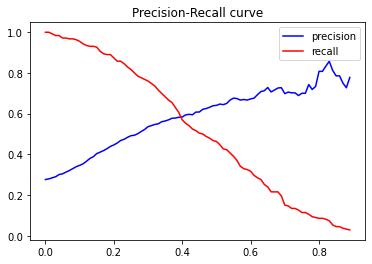

In [25]:
plot_precision_recall(thresholds, precision_matrix, recall_matrix)

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

> The curves intersect approximately at: 0.4

In [26]:
for i in range(len(thresholds)):
    if precision_matrix[i] > recall_matrix[i]:
        print(f'The curves intersect approximately at: {thresholds[i]}')
        break


The curves intersect approximately at: 0.4


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$ F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}  $$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [27]:
def compute_f1(precision_matrix, recall_matrix):
    f1 = []

    for i in range(len(precision_matrix)):
        score = (2 * (precision_matrix[i] * recall_matrix[i])) / (precision_matrix[i] + recall_matrix[i])
        f1.append(score)
    return f1

f1_score = compute_f1(precision_matrix, recall_matrix)
print(
    f'Threshold value for maximal F1 score of model is: {thresholds[np.argmax(f1_score)]}\n'
    f'Maximal F1 score of model is: {round(f1_score[np.argmax(f1_score)], 3)}'
)

Threshold value for maximal F1 score of model is: 0.3
Maximal F1 score of model is: 0.629


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

>Threshold value for maximal F1 score of model is: 0.3

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [28]:
cat_cols+num_cols

['home',
 'marital',
 'records',
 'job',
 'seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

In [83]:
def transform_train(df_train,y_train,C=1.0 ):
    """
    a. Create and vectorize train dictionary
    b. Train model
    c. Return the vectorizer and the model
    """
    train_dict = df_train[cat_cols+num_cols].to_dict(orient= 'records')
    
    dv = DictVectorizer(sparse= False)
    X_train = dv.fit_transform(train_dict)
    
    logreg = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    logreg.fit(X_train, y_train)
    
    return dv, logreg

In [84]:
def predict(df, dv, model):
    pred_df = df[cat_cols+num_cols].to_dict(orient= 'records')
    
    pred_dict = dv.transform(pred_df)
    
    y_pred = model.predict_proba(pred_dict)[:, 1] 
    
    return y_pred

In [45]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import warnings

warnings.filterwarnings("ignore")

In [80]:


def kfold_auc(df, c_range, split=5, random_state=1):
    c_scores = []
    for c in tqdm(c_range):
        scores = []
        kf = KFold(n_splits=split, shuffle=True, random_state=1)

        for train_idx, val_idx in kf.split(df):
    #         print(f'Train: {train_idx} \n Test: {val_idx}')
            X_train, X_val = df.iloc[train_idx], df.iloc[val_idx]
            y_train, y_val = X_train.default.values, X_val.default.values

            dv, lr_model = transform_train(X_train, y_train, C=c)

            y_pred = predict(X_val, dv, lr_model)

            lr_auc = roc_auc_score(y_val, y_pred)

            scores.append(lr_auc)

#         print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))
        c_scores.append(scores)
    return c_scores


In [85]:
split = 5

c_range = [1]

q5_scores = kfold_auc(df, c_range, split=5, random_state=1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [86]:
a5 = [round(np.std(value), 3) for value in q5_scores]
a5

[0.012]

How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

> C=1 0.835 +- **_0.013_**  

>    **0.014**

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [71]:
c_range_6 = [0.01, 0.1, 1, 10]
q6_scores = kfold_auc(df, c_range_6,split=5, random_state=1)

  0%|          | 0/4 [00:00<?, ?it/s]

In [76]:
a6 = [(round(np.mean(score), 3), round(np.std(score), 3)) for score in q6_scores]
a6

[(0.832, 0.013), (0.838, 0.012), (0.836, 0.012), (0.836, 0.013)]

In [77]:
list(zip(c_range_6, a6))

[(0.01, (0.832, 0.013)),
 (0.1, (0.838, 0.012)),
 (1, (0.836, 0.012)),
 (10, (0.836, 0.013))]

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

> 0.838 -> 0.1

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.